# 1. Imports

In [1]:
# %% Cell 1: Imports
import os
import random
import glob
import datetime
import time
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt
# Try importing notebook-specific tools
try:
    from tqdm.notebook import tqdm as notebook_tqdm
    from IPython.display import display, clear_output
    IS_NOTEBOOK = True
    print("Notebook environment detected. Using notebook-specific tqdm and display.")
except ImportError:
    from tqdm.auto import tqdm as notebook_tqdm # Fallback if not in standard notebook
    IS_NOTEBOOK = False
    print("Notebook environment not fully detected or IPython not installed. Using standard tqdm.")
    # Define dummy clear_output if not available
    def clear_output(wait=False):
        pass


# Import necessary components from diffusers
from diffusers import AutoencoderTiny, UNet2DConditionModel, DDPMScheduler

# Set Matplotlib to display plots inline in notebooks
%matplotlib inline

Notebook environment detected. Using notebook-specific tqdm and display.


# 2: Configuration Class

In [2]:
class TrainingConfig:
    # --- Data ---
    ROOT_DIR = "/cwStorage/nodecw_group/jijh/hest_output" #<-- CHANGE THIS TO YOUR DATA PATH
    TARGET_SIZE = (512, 512) # Image size
    IMAGE_EXTS = ['.png', '.jpg', '.jpeg']
    VAE_MAX_SAMPLES = 10000     # Samples for VAE finetuning (if done)
    DIFFUSION_MAX_SAMPLES = 800000 # Samples for Diffusion training (e.g., 12k or 310k)

    # --- VAE ---
    VAE_BATCH_SIZE = 32 # Smaller batch size might be needed for VAE fine-tuning on some GPUs
    VAE_NUM_EPOCHS = 5 # Fewer epochs often suffice for fine-tuning
    VAE_LEARNING_RATE = 5e-5 # Lower LR for fine-tuning
    VAE_LATENT_CHANNELS = 4
    VAE_USE_PRETRAINED = True
    VAE_SD_VERSION = 'v2.1' # or 'sdxl'
    VAE_SAVE_IMAGES = False # Keep False for notebooks unless needed
    VAE_OUTPUT_DIR = 'vae_logs_notebook'
    VAE_MODEL_PATH = "/cwStorage/nodecw_group/jijh/model_path/finetuned_taesd_v21_notebook.pt" # Path to save/load finetuned VAE

    # --- Diffusion (UNet) ---
    DIFFUSION_BATCH_SIZE = 32 # Adjust based on GPU memory (start lower in notebooks)
    DIFFUSION_NUM_EPOCHS = 15
    DIFFUSION_LEARNING_RATE = 1e-4
    ACCUMULATION_STEPS = 4    # Gradient Accumulation (effective batch size = BATCH_SIZE * ACCUMULATION_STEPS)
    UNET_SAMPLE_SIZE = 64     # Latent dimension (TARGET_SIZE // 8)
    UNET_IN_CHANNELS = 4      # VAE latent channels
    UNET_OUT_CHANNELS = 4     # VAE latent channels
    UNET_BLOCK_OUT_CHANNELS = (320, 640, 1280, 1280) # Example like SD v1/v2
    UNET_DOWN_BLOCK_TYPES = ('CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D')
    UNET_UP_BLOCK_TYPES = ('UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D')
    UNET_CROSS_ATTENTION_DIM = 768 # Dimension for condition (using dummy for unconditional) - Use 1024 for SDXL VAEs/UNets
    SCHEDULER_TRAIN_TIMESTEPS = 1000
    SAMPLING_INFERENCE_STEPS = 50
    SAMPLING_BATCH_SIZE = 4 # How many images to generate for visualization/testing during training
    SAMPLING_FINAL_BATCH_SIZE = 16 # How many images to generate at the very end

    # --- Training & Logging ---
    DEVICE_NAME = "cuda:1"    # Specify GPU (e.g., "cuda:0", "cuda:1") or "cpu"
    NUM_WORKERS = 4
    CHECKPOINT_DIR = "/cwStorage/nodecw_group/jijh/model_path/" # <-- CHANGE THIS TO YOUR CHECKPOINT PATH
    LOG_DIR = "/home1/jijh/diffusion_project/ADiffusion/logs_notebook" # <-- CHANGE THIS TO YOUR LOG PATH

    @classmethod
    def get_checkpoint_path(cls):
        # Dynamic checkpoint naming based on parameters
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True) # Ensure dir exists
        return os.path.join(
            cls.CHECKPOINT_DIR,
            f"unet_cond_uncond_notebook_bs{cls.DIFFUSION_BATCH_SIZE}_"
            f"ep{cls.DIFFUSION_NUM_EPOCHS}_lr{cls.DIFFUSION_LEARNING_RATE}_"
            f"samples{cls.DIFFUSION_MAX_SAMPLES}_"
            f"acc{cls.ACCUMULATION_STEPS}.pt"
        )


# 3: Dataset Definition

In [15]:
from tqdm import tqdm
class TilesDataset(Dataset):
    """
    Loads images from subdirectories, resizes, and normalizes to [-1, 1].
    """
    def __init__(self, root_dir, target_size=(512, 512), image_exts=['.png', '.jpg', '.jpeg'], max_samples=None):
        self.root_dir = root_dir
        self.target_size = target_size
        self.image_paths = []
        if not os.path.isdir(root_dir):
             raise FileNotFoundError(f"Root directory not found: {root_dir}")

        subfolders = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))]
        if not subfolders:
            print(f"Warning: No subfolders found in {root_dir}. Searching directly in root_dir.")
            subfolders = [root_dir] # Search directly in root if no subfolders

        print(f"Searching for images in: {subfolders}")
        for folder in tqdm(subfolders):
            for ext in image_exts:
                self.image_paths.extend(glob.glob(os.path.join(folder, f'*{ext}')))

        if not self.image_paths:
             raise FileNotFoundError(f"No images found with extensions {image_exts} in {root_dir} and its subdirectories.")

        if max_samples is not None and len(self.image_paths) > max_samples:
            print(f"Sampling {max_samples} images from {len(self.image_paths)} found.")
            self.image_paths = random.sample(self.image_paths, max_samples)
        print(f"Initialized dataset with {len(self.image_paths)} images.")

        self.transform = transforms.Compose([
            transforms.Resize(target_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),  # [0,1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # to [-1,1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)
            return image
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # In a notebook, skipping might be okay for a few images, but raising is safer
            raise e


# 4: VAE Utility Functions

In [ ]:
def get_vae_model(config: TrainingConfig):
    """Gets the VAE model (pretrained TinyVAE or new)."""
    if config.VAE_USE_PRETRAINED:
        model_name = "madebyollin/taesd" if config.VAE_SD_VERSION == 'v2.1' else "madebyollin/taesdxl"
        try:
            # Ensure transformers is updated if facing import errors with AutoencoderTiny
            vae = AutoencoderTiny.from_pretrained(model_name, torch_dtype=torch.float32)
            print(f"Loaded pretrained Tiny AutoEncoder: {model_name}")
        except Exception as e:
             print(f"Error loading pretrained VAE {model_name}: {e}. Creating new one.")
             vae = AutoencoderTiny(latent_channels=config.VAE_LATENT_CHANNELS) # Basic config
             print("Created new Tiny AutoEncoder model from scratch.")
    else:
        vae = AutoencoderTiny(
            in_channels=3, out_channels=3, latent_channels=config.VAE_LATENT_CHANNELS,
            # Add other relevant params from TAESD defaults if needed
        )
        print("Created new Tiny AutoEncoder model from scratch.")
    # Add scaling_factor to config if it doesn't exist for consistency, TAESD defaults to 1.0
    if not hasattr(vae.config, 'scaling_factor'):
        vae.config.scaling_factor = 1.0
    return vae

# --- MODIFIED Loss Function ---
def compute_vae_loss(vae, images):
    """
    Computes VAE reconstruction loss (MSE) for AutoencoderTiny.
    KL divergence is not calculated as TinyVAE doesn't expose mu/logvar.
    """
    amp_enabled = images.device.type == 'cuda'
    with autocast(enabled=amp_enabled):
        # AutoencoderTiny's encode returns AutoencoderTinyOutput(latents=...)
        encoded_output = vae.encode(images)
        latents = encoded_output.latents # Directly access latents

        # TinyVAE typically doesn't use the same scaling factor concept as KL-VAE during encode/decode
        # Check its forward pass or specific usage if needed, but usually, decode takes raw latents.
        # Let's assume direct decoding here based on TAESD usage patterns.
        decoded_output = vae.decode(latents) # Pass latents directly
        recon_images = decoded_output.sample

        # Calculate only reconstruction loss
        recon_loss = F.mse_loss(recon_images, images, reduction='mean')
        total_loss = recon_loss
        # Set kl_loss to zero or None for consistent return signature if needed elsewhere
        kl_loss = torch.tensor(0.0, device=images.device)

    return total_loss, recon_loss, kl_loss # Return 0 for KL loss

# --- MODIFIED Image Logging ---
def log_vae_images(vae, dataloader, device, epoch, config: TrainingConfig):
    """Logs original vs reconstructed images. Clears output in notebook."""
    vae.eval()
    try:
        # Ensure dataloader provides a batch
        images = next(iter(dataloader))
        if images is None or len(images) == 0:
             print("DataLoader returned empty batch, cannot generate VAE log image.")
             vae.train()
             return
    except StopIteration:
        print("DataLoader exhausted, cannot generate VAE log image.")
        vae.train()
        return

    images = images.to(device)
    amp_enabled = images.device.type == 'cuda'

    with torch.no_grad(), autocast(enabled=amp_enabled):
        encoded_output = vae.encode(images)
        latents = encoded_output.latents # Get latents directly
        decoded_output = vae.decode(latents) # Decode latents directly
        recon_images = decoded_output.sample

    num_show = min(8, images.size(0))
    comparison = torch.cat([images[:num_show], recon_images[:num_show]], dim=0)
    grid = make_grid(comparison, nrow=num_show, normalize=True, value_range=(-1, 1))

    if IS_NOTEBOOK:
        clear_output(wait=True)

    plt.figure(figsize=(12, 3 * (comparison.size(0) // num_show) if num_show > 0 else 3 ))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"VAE Epoch {epoch}: Original (top) vs Reconstructed (bottom)")
    plt.axis('off')
    plt.show()

    if config.VAE_SAVE_IMAGES:
        os.makedirs(config.VAE_OUTPUT_DIR, exist_ok=True)
        save_path = os.path.join(config.VAE_OUTPUT_DIR, f'vae_orig_recon_epoch_{epoch}.png')
        save_image(comparison, save_path, nrow=num_show, normalize=True, value_range=(-1, 1))
        print(f"Saved VAE comparison image to {save_path}")
    vae.train()

# --- MODIFIED Training Loop ---
def train_vae(vae, dataloader, optimizer, device, config: TrainingConfig):
    """Trains the VAE model (TinyVAE focused). Uses notebook tqdm and output clearing."""
    vae.train()
    amp_enabled = device.type == 'cuda'
    scaler = GradScaler(enabled=amp_enabled)

    print("Starting VAE Fine-tuning (TinyVAE - Reconstruction Loss Only)...")
    for epoch in range(1, config.VAE_NUM_EPOCHS + 1):
        epoch_loss, epoch_recon = 0.0, 0.0 # Removed epoch_kl tracking
        progress_bar = notebook_tqdm(dataloader, desc=f"VAE Epoch {epoch}/{config.VAE_NUM_EPOCHS}", leave=False)

        for batch_idx, images in enumerate(progress_bar):
            if images is None: continue # Skip if dataloader had an error
            images = images.to(device)
            optimizer.zero_grad()

            loss, recon_loss, _ = compute_vae_loss(vae, images) # Ignore KL loss return

            if amp_enabled:
                 scaler.scale(loss).backward()
                 scaler.step(optimizer)
                 scaler.update()
            else:
                 loss.backward()
                 optimizer.step()

            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()

            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Recon": f"{recon_loss.item():.4f}", # Removed KL display
            })

        avg_loss = epoch_loss / len(dataloader)
        avg_recon = epoch_recon / len(dataloader)
        # Removed avg_kl calculation and printing
        print(f"VAE Epoch {epoch} completed: Avg Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}")

        # Log images at the end of each epoch
        log_vae_images(vae, dataloader, device, epoch, config)

    print("VAE Fine-tuning finished!")
    os.makedirs(os.path.dirname(config.VAE_MODEL_PATH), exist_ok=True)
    torch.save(vae.state_dict(), config.VAE_MODEL_PATH)
    print(f"Fine-tuned VAE saved to {config.VAE_MODEL_PATH}")
    return vae

# 5: Diffusion Model (UNet) Utilities

In [5]:
def get_diffusion_unet_and_scheduler(config: TrainingConfig):
    """Returns the UNet2DConditionModel and DDPMScheduler."""
    model = UNet2DConditionModel(
        sample_size=config.UNET_SAMPLE_SIZE,
        in_channels=config.UNET_IN_CHANNELS,
        out_channels=config.UNET_OUT_CHANNELS,
        layers_per_block=2,
        block_out_channels=config.UNET_BLOCK_OUT_CHANNELS,
        down_block_types=config.UNET_DOWN_BLOCK_TYPES,
        up_block_types=config.UNET_UP_BLOCK_TYPES,
        cross_attention_dim=config.UNET_CROSS_ATTENTION_DIM,
        # attention_head_dim=8 # Often 8 heads per 64 dim
    )
    scheduler = DDPMScheduler(num_train_timesteps=config.SCHEDULER_TRAIN_TIMESTEPS)
    print(f"UNet2DConditionModel created with cross_attention_dim={config.UNET_CROSS_ATTENTION_DIM}")
    print(f"DDPMScheduler created with {config.SCHEDULER_TRAIN_TIMESTEPS} timesteps.")
    return model, scheduler

def sample_latent_diffusion(unet, vae, scheduler, device, config: TrainingConfig, num_inference_steps=None, sample_batch_size=None):
    """Generates images from noise using the trained UNet and fixed VAE."""
    unet.eval()
    vae.eval()

    _num_steps = num_inference_steps if num_inference_steps is not None else config.SAMPLING_INFERENCE_STEPS
    _batch_size = sample_batch_size if sample_batch_size is not None else config.SAMPLING_BATCH_SIZE

    # Determine model data type and device for generating noise and conditions
    model_dtype = next(unet.parameters()).dtype
    amp_enabled = device.type == 'cuda'

    latent_shape = (_batch_size, config.UNET_IN_CHANNELS, config.UNET_SAMPLE_SIZE, config.UNET_SAMPLE_SIZE)
    # Generate noise matching the model's dtype and device
    latents = torch.randn(latent_shape, device=device, dtype=model_dtype)

    # Prepare dummy encoder hidden states for unconditional generation
    dummy_encoder_hidden_states = torch.zeros(
        _batch_size, 1, config.UNET_CROSS_ATTENTION_DIM,
        device=device, dtype=model_dtype # Match UNet dtype
    )

    scheduler.set_timesteps(_num_steps)
    # Use notebook_tqdm for sampling progress
    progress_bar = notebook_tqdm(scheduler.timesteps, desc="Sampling", leave=False)
    for t in progress_bar:
        # expand the latents if we are doing classifier free guidance (not used here)
        # latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = latents # Unconditional
        latent_model_input = scheduler.scale_model_input(latent_model_input, t) # Some schedulers require scaling

        with torch.no_grad(), autocast(enabled=amp_enabled):
            noise_pred = unet(
                sample=latent_model_input,
                timestep=t,
                encoder_hidden_states=dummy_encoder_hidden_states
            ).sample

        # compute the previous noisy sample x_t -> x_{t-1}
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode the final latents
    with torch.no_grad(), autocast(enabled=amp_enabled):
        scale_factor = getattr(vae.config, "scaling_factor", 0.18215)
        latents_to_decode = latents / scale_factor
        decoded = vae.decode(latents_to_decode).sample

    images = (decoded.clamp(-1, 1) + 1) / 2  # Map to [0, 1]
    images = images.cpu().float() # Move to CPU and ensure float32 for visualization
    unet.train() # Set UNet back to train mode
    return images


# 6: Checkpoint Save and Load Functions

In [6]:
def save_checkpoint(epoch, unet, optimizer, lr_scheduler, config: TrainingConfig):
    """Saves model, optimizer, and scheduler state."""
    checkpoint_path = config.get_checkpoint_path()
    checkpoint = {
        'epoch': epoch,
        'unet_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict() if lr_scheduler else None,
        # Optional: Save config details for reproducibility
        'config': {k: v for k, v in config.__dict__.items() if not k.startswith('__') and not callable(v)},
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} to {checkpoint_path}")

def load_checkpoint(unet, optimizer, lr_scheduler, config: TrainingConfig):
    """Loads checkpoint and returns start epoch."""
    checkpoint_path = config.get_checkpoint_path()
    start_epoch = 0
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location='cpu') # Load to CPU first

        # Clean state dict keys if needed (e.g., remove 'module.' prefix)
        unet_state_dict = checkpoint['unet_state_dict']
        if any(key.startswith('module.') for key in unet_state_dict.keys()):
            print("Removing 'module.' prefix from state dict keys.")
            unet_state_dict = {k.replace('module.', ''): v for k, v in unet_state_dict.items()}

        try:
            unet.load_state_dict(unet_state_dict)
        except RuntimeError as e:
             print(f"Error loading UNet state dict (possibly due to architecture mismatch): {e}")
             print("Trying to load with strict=False (may ignore incompatible keys)")
             unet.load_state_dict(unet_state_dict, strict=False)


        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            # Move optimizer states to the correct device
            target_device = torch.device(config.DEVICE_NAME if torch.cuda.is_available() and config.DEVICE_NAME.startswith("cuda") else "cpu")
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(target_device)
        except Exception as e:
            print(f"Warning: Could not load optimizer state: {e}. Optimizer will start from scratch.")


        if lr_scheduler and checkpoint.get('lr_scheduler_state_dict'):
             try:
                 lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
             except Exception as e:
                 print(f"Warning: Could not load LR scheduler state: {e}. Scheduler will start from scratch.")

        start_epoch = checkpoint.get('epoch', -1) + 1 # Use get for safety
        print(f"Resuming training from epoch {start_epoch}")

        # You could potentially load and compare saved config vs current config here
        # saved_config = checkpoint.get('config', {})
        # compare_configs(saved_config, config)

    else:
        print(f"No checkpoint found at {checkpoint_path}. Training from scratch.")
    return start_epoch

# 7: Diffusion Model Training Function

In [22]:
# %% Cell 7: Diffusion Model Training Function (MODIFIED for AutoencoderTiny)
def train_diffusion_model(
    vae, unet, scheduler, dataloader, optimizer, device,
    config: TrainingConfig, writer: SummaryWriter, lr_scheduler=None,
    start_epoch=0):
    """Trains the UNet diffusion model unconditionally. Uses notebook features."""
    unet.train()
    vae.eval() # VAE is fixed
    amp_enabled = device.type == 'cuda'
    scaler = GradScaler(enabled=amp_enabled)
    # Calculate global step offset based on start epoch and dataloader length
    num_update_steps_per_epoch = len(dataloader) // config.ACCUMULATION_STEPS
    global_step = start_epoch * num_update_steps_per_epoch

    print(f"Starting UNet training from epoch {start_epoch+1}/{config.DIFFUSION_NUM_EPOCHS}...")
    total_start_time = time.time()

    for epoch in range(start_epoch, config.DIFFUSION_NUM_EPOCHS):
        epoch_loss = 0.0
        epoch_start_time = time.time()
        progress_bar = notebook_tqdm(dataloader, desc=f"UNet Epoch {epoch+1}/{config.DIFFUSION_NUM_EPOCHS}", leave=False)
        optimizer.zero_grad() # Clear gradients at the start

        for batch_idx, images in enumerate(progress_bar):
            if images is None: continue # Skip bad batches if collate_fn handles it
            images = images.to(device)

            # --- MODIFIED SECTION for AutoencoderTiny ---
            # 1. Encode images to latent space
            with torch.no_grad(), autocast(enabled=amp_enabled):
                encoded_output = vae.encode(images) # B, C, H, W
                latents = encoded_output.latents # Get latents directly
                # No scaling factor needed here based on typical TAESD usage for diffusion input
            # --- END OF MODIFIED SECTION ---

            # 2. Sample noise and timesteps
            noise = torch.randn_like(latents)
            b = latents.shape[0]
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (b,), device=device).long()

            # 3. Add noise to latents
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            # 4. Prepare dummy condition
            dummy_encoder_hidden_states = torch.zeros(
                b, 1, config.UNET_CROSS_ATTENTION_DIM,
                device=device, dtype=unet.dtype # Match UNet dtype
            )

            # 5. Predict noise using UNet
            with autocast(enabled=amp_enabled):
                # Scale model input if needed by scheduler
                noisy_latents_input = scheduler.scale_model_input(noisy_latents, timesteps)

                noise_pred = unet(
                    sample=noisy_latents_input,
                    timestep=timesteps,
                    encoder_hidden_states=dummy_encoder_hidden_states
                ).sample
                loss = F.mse_loss(noise_pred.float(), noise.float()) # Calculate loss in float32
                loss = loss / config.ACCUMULATION_STEPS # Scale loss

            # 6. Backpropagate
            if amp_enabled:
                 scaler.scale(loss).backward()
            else:
                 loss.backward()

            # Accumulate unscaled loss for logging
            epoch_loss += loss.item() * config.ACCUMULATION_STEPS

            # 7. Optimizer Step (Accumulation)
            if (batch_idx + 1) % config.ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(dataloader):
                if amp_enabled:
                     scaler.step(optimizer)
                     scaler.update()
                else:
                     optimizer.step()

                if lr_scheduler is not None:
                     lr_scheduler.step()

                optimizer.zero_grad()
                global_step += 1

                writer.add_scalar('Train/Batch_Loss', loss.item() * config.ACCUMULATION_STEPS, global_step)
                writer.add_scalar('Train/Learning_Rate_Step', optimizer.param_groups[0]['lr'], global_step)

            progress_bar.set_postfix(loss=f"{loss.item()*config.ACCUMULATION_STEPS:.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

        # --- End of Epoch ---
        avg_loss = epoch_loss / len(dataloader.dataset) * config.DIFFUSION_BATCH_SIZE # Avg loss per image
        epoch_duration = time.time() - epoch_start_time
        total_elapsed = time.time() - total_start_time
        avg_epoch_time = total_elapsed / (epoch - start_epoch + 1)
        estimated_remaining = avg_epoch_time * (config.DIFFUSION_NUM_EPOCHS - epoch - 1)

        current_lr = optimizer.param_groups[0]['lr'] # Get current LR

        print(f"\nUNet Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}, LR: {current_lr:.2e}, "
              f"Time: {str(datetime.timedelta(seconds=int(epoch_duration)))}, "
              f"Total Time: {str(datetime.timedelta(seconds=int(total_elapsed)))}, "
              f"ETA: {str(datetime.timedelta(seconds=int(estimated_remaining)))}")

        # Log epoch metrics
        writer.add_scalar('Train/Epoch_Avg_Loss', avg_loss, epoch+1)
        writer.add_scalar('Train/Epoch_Duration_sec', epoch_duration, epoch+1)
        writer.add_scalar('Train/Learning_Rate_Epoch', current_lr, epoch+1)

        # Generate and log sample images (clear output in notebook)
        if (epoch + 1) % 1 == 0: # Sample every epoch
            print("Generating samples...")
            gen_images = sample_latent_diffusion(unet, vae, scheduler, device, config)

            if IS_NOTEBOOK:
                clear_output(wait=True) # Clear previous plot before showing new one
                # Re-print epoch summary after clearing output
                print(f"\nUNet Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}, LR: {current_lr:.2e}, "
                      f"Time: {str(datetime.timedelta(seconds=int(epoch_duration)))}, "
                      f"Total Time: {str(datetime.timedelta(seconds=int(total_elapsed)))}, "
                      f"ETA: {str(datetime.timedelta(seconds=int(estimated_remaining)))}")

            grid = make_grid(gen_images, nrow=config.SAMPLING_BATCH_SIZE // 2 if config.SAMPLING_BATCH_SIZE > 1 else 1, normalize=True, value_range=(0, 1))
            plt.figure(figsize=(8, 8)) # Adjust size as needed
            plt.imshow(grid.permute(1, 2, 0).numpy()) # No .cpu() needed as sample func returns CPU tensor
            plt.axis("off")
            plt.title(f"UNet Epoch {epoch+1} Sample Output")
            plt.show() # Display plot in notebook

            writer.add_image('Train/Generated_Samples', grid, epoch+1)

        # Save checkpoint
        save_checkpoint(epoch, unet, optimizer, lr_scheduler, config)

    print(f"UNet training finished! Total time: {str(datetime.timedelta(seconds=int(time.time() - total_start_time)))}")

# 8: Main Function Definition

In [9]:
config = TrainingConfig()

# --- Device Setup ---
if torch.cuda.is_available() and config.DEVICE_NAME.startswith("cuda"):
    device = torch.device(config.DEVICE_NAME)
    try:
        torch.cuda.set_device(device) # Set default device
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"Could not set GPU device {config.DEVICE_NAME}, falling back to CPU. Error: {e}")
        device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"Selected device: {device}")


Using GPU: NVIDIA H100 PCIe
Selected device: cuda:1


In [10]:
# --- VAE Setup ---
vae = get_vae_model(config)
# Option 1: Try to load a previously fine-tuned VAE
if config.VAE_USE_PRETRAINED and os.path.exists(config.VAE_MODEL_PATH):
        print(f"Attempting to load fine-tuned VAE from {config.VAE_MODEL_PATH}")
        try:
            vae.load_state_dict(torch.load(config.VAE_MODEL_PATH, map_location='cpu'))
            print("Successfully loaded fine-tuned VAE.")
        except Exception as e:
            print(f"Could not load fine-tuned VAE state dict from {config.VAE_MODEL_PATH}: {e}")
            print("Proceeding with the default Hugging Face pretrained VAE.")
elif config.VAE_USE_PRETRAINED:
    print(f"VAE model path {config.VAE_MODEL_PATH} not found. Using default Hugging Face pretrained VAE.")


Loaded pretrained Tiny AutoEncoder: madebyollin/taesd
VAE model path /cwStorage/nodecw_group/jijh/model_path/finetuned_taesd_v21_notebook.pt not found. Using default Hugging Face pretrained VAE.


In [ ]:
# Optional: Fine-tune the VAE if needed (uncomment section below)
print("--- Starting VAE Fine-tuning Phase ---")
vae_dataset = TilesDataset(root_dir=config.ROOT_DIR, target_size=config.TARGET_SIZE, max_samples=config.VAE_MAX_SAMPLES)
# Filter out None items potentially returned by dataset __getitem__ on error
vae_dataloader = DataLoader(vae_dataset, batch_size=config.VAE_BATCH_SIZE, shuffle=True,
                            num_workers=config.NUM_WORKERS, pin_memory=True,
                            collate_fn=lambda b: torch.stack([x for x in b if x is not None]))


--- Starting VAE Fine-tuning Phase ---
Searching for images in: ['/cwStorage/nodecw_group/jijh/hest_output/TENX105_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI861_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI146_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI192_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI563_tiles', '/cwStorage/nodecw_group/jijh/hest_output/SPA45_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI462_expr', '/cwStorage/nodecw_group/jijh/hest_output/MISC107_tiles', '/cwStorage/nodecw_group/jijh/hest_output/MISC58_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI434_tiles', '/cwStorage/nodecw_group/jijh/hest_output/TENX24_expr', '/cwStorage/nodecw_group/jijh/hest_output/MEND35_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI296_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI492_expr', '/cwStorage/nodecw_group/jijh/hest_output/SPA3_expr', '/cwStorage/nodecw_group/jijh/hest_output/TENX136_expr', '/cwStorage/nodecw_grou

/tmp/ipykernel_10554/4283748130.py:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


VAE Epoch 1/5:   0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipykernel_10554/4283748130.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


AttributeError: 'AutoencoderTinyOutput' object has no attribute 'latent_dist'

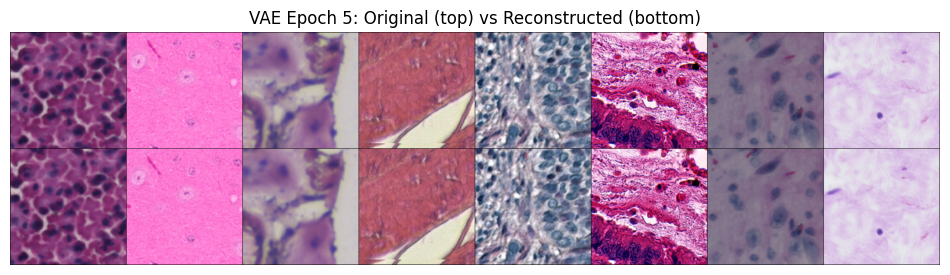

VAE Fine-tuning finished!
Fine-tuned VAE saved to /cwStorage/nodecw_group/jijh/model_path/finetuned_taesd_v21_notebook.pt
--- VAE Fine-tuning Complete ---


In [13]:
vae.to(device)
vae_optimizer = optim.AdamW(vae.parameters(), lr=config.VAE_LEARNING_RATE) # Use AdamW
trained_vae = train_vae(vae, vae_dataloader, vae_optimizer, device, config)
vae = trained_vae # Update vae reference to the trained one
print("--- VAE Fine-tuning Complete ---")
# --- End of Optional VAE Fine-tuning ---

In [14]:
vae.to(device)
vae.eval()

AutoencoderTiny(
  (encoder): EncoderTiny(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip): Identity()
        (fuse): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (3): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [24]:
config.DIFFUSION_MAX_SAMPLES = 30000 # Adjust for diffusion training
# --- Diffusion Model Setup ---
print("--- Starting Diffusion Model Training Phase ---")
print("Setting up Diffusion Dataset...")
diffusion_dataset = TilesDataset(root_dir=config.ROOT_DIR, target_size=config.TARGET_SIZE, max_samples=config.DIFFUSION_MAX_SAMPLES)
diffusion_dataloader = DataLoader(diffusion_dataset, batch_size=config.DIFFUSION_BATCH_SIZE, shuffle=True,
                                    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True,
                                    collate_fn=lambda b: torch.stack([x for x in b if x is not None])) # Handle potential errors

print("Setting up Diffusion Model (UNet), Scheduler, Optimizer...")
unet, scheduler = get_diffusion_unet_and_scheduler(config)
unet.to(device)

optimizer = optim.AdamW(unet.parameters(), lr=config.DIFFUSION_LEARNING_RATE, weight_decay=1e-3) # AdamW with weight decay

--- Starting Diffusion Model Training Phase ---
Setting up Diffusion Dataset...
Searching for images in: ['/cwStorage/nodecw_group/jijh/hest_output/TENX105_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI861_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI146_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI192_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI563_tiles', '/cwStorage/nodecw_group/jijh/hest_output/SPA45_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI462_expr', '/cwStorage/nodecw_group/jijh/hest_output/MISC107_tiles', '/cwStorage/nodecw_group/jijh/hest_output/MISC58_tiles', '/cwStorage/nodecw_group/jijh/hest_output/NCBI434_tiles', '/cwStorage/nodecw_group/jijh/hest_output/TENX24_expr', '/cwStorage/nodecw_group/jijh/hest_output/MEND35_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI296_expr', '/cwStorage/nodecw_group/jijh/hest_output/NCBI492_expr', '/cwStorage/nodecw_group/jijh/hest_output/SPA3_expr', '/cwStorage/nodecw_group/jijh/hest_outp

100%|██████████| 2458/2458 [00:11<00:00, 214.99it/s]


Sampling 30000 images from 2104169 found.
Initialized dataset with 30000 images.
Setting up Diffusion Model (UNet), Scheduler, Optimizer...
UNet2DConditionModel created with cross_attention_dim=768
DDPMScheduler created with 1000 timesteps.


In [25]:
# Calculate total training steps for the scheduler
num_update_steps_per_epoch = len(diffusion_dataloader) // config.ACCUMULATION_STEPS
total_train_steps = config.DIFFUSION_NUM_EPOCHS * num_update_steps_per_epoch

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=total_train_steps, # Total number of optimizer steps
    eta_min=1e-6
)
print(f"LR Scheduler: Cosine Annealing with T_max={total_train_steps} steps.")

LR Scheduler: Cosine Annealing with T_max=3510 steps.


In [26]:
# --- Load Checkpoint ---
start_epoch = load_checkpoint(unet, optimizer, lr_scheduler, config)
# Ensure model is back on device after loading from CPU map_location
unet.to(device)

No checkpoint found at /cwStorage/nodecw_group/jijh/model_path/unet_cond_uncond_notebook_bs32_ep15_lr0.0001_samples800000_acc4.pt. Training from scratch.


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [27]:
# --- TensorBoard Setup ---
os.makedirs(config.LOG_DIR, exist_ok=True)
# Add timestamp to logdir to prevent overwriting runs
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_log_dir = os.path.join(config.LOG_DIR, f"run_{current_time}")
writer = SummaryWriter(log_dir=run_log_dir)
print(f"TensorBoard logs will be saved to: {run_log_dir}")

TensorBoard logs will be saved to: /home1/jijh/diffusion_project/ADiffusion/logs_notebook/run_20250401-220705



UNet Epoch 15 completed. Avg Loss: 0.0760, LR: 1.00e-06, Time: 0:10:37, Total Time: 2:45:28, ETA: 0:00:00


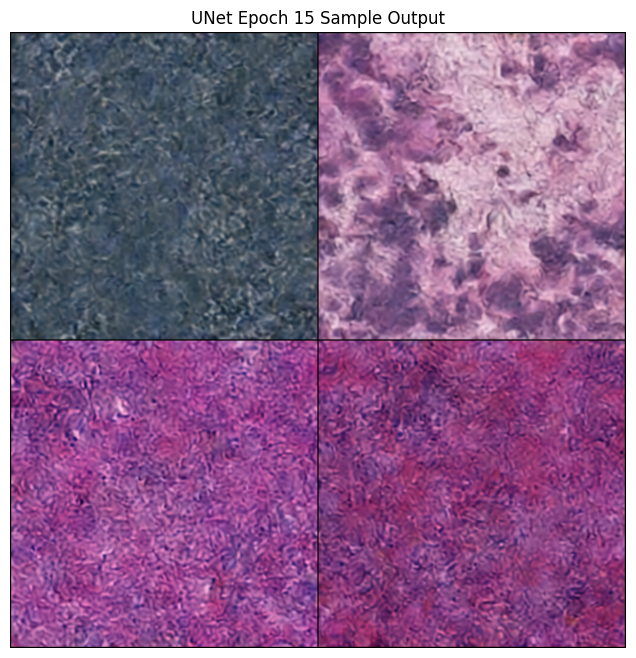

Checkpoint saved at epoch 14 to /cwStorage/nodecw_group/jijh/model_path/unet_cond_uncond_notebook_bs32_ep15_lr0.0001_samples800000_acc4.pt
UNet training finished! Total time: 2:45:53


In [28]:
# --- Start Training ---
train_diffusion_model(
    vae=vae,
    unet=unet,
    scheduler=scheduler,
    dataloader=diffusion_dataloader,
    optimizer=optimizer,
    device=device,
    config=config,
    writer=writer,
    lr_scheduler=lr_scheduler,
    start_epoch=start_epoch
)